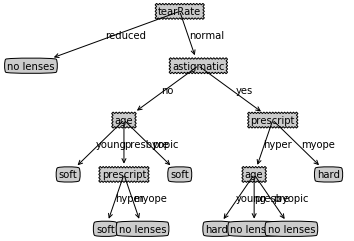

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'no': {'age': {'young': 'soft', 'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}, 'pre': 'soft'}}, 'yes': {'prescript': {'hyper': {'age': {'young': 'hard', 'presbyopic': 'no lenses', 'pre': 'no lenses'}}, 'myope': 'hard'}}}}}}


In [2]:
from math import log
import operator
import treePlotter


def cal_shannon_ent(dateset):
    """
    函数作用：计算给定数据集的香农熵
    :param dateset: 给定的数据集
    :return: 香农熵
    """
    # 计算data_set的大小
    num_ents = len(dateset)
    # 为所有可能的分类创建字典
    label_counts = {}
    # 遍历data_set数据集
    for feat_vec in dateset:
        # 每行的最后一个为label标签
        current_label = feat_vec[-1]
        # 如果label不在字典中，则创建key，并赋值为0-value;否则，加1
        if current_label not in label_counts.keys():
            label_counts[current_label] = 0
        label_counts[current_label] += 1
    # 计算香农熵，并返回
    shannon_ent = 0.0
    for key in label_counts:
        # 计算label_counts[key]的概率
        prob = float(label_counts[key]) / num_ents
        # 香农熵(信息熵,信息期望值)
        shannon_ent -= prob * log(prob, 2)
    return shannon_ent


def split_dataset(dataset, axis, value):
    """
    函数作用：按照给定特征axis，划分数据集
    :param dataset: 待划分的数据集
    :param axis: 划分数据集的特征(第几个特征)
    :param value: 需要返回的特征的值(相应特征的值)
    :return: 给定特征axis的值(除了相应特征的值没有，剩下的全部都有)
    """
    # 在函数内部对列表对象的修改，将会影响该列表对象的整个生存周期
    # 所以新建一个列表对象
    ret_data_set = []
    # 遍历数据集
    for feat_vec in dataset:
        # 如果在数据集里找到给定特征的值，则除了该特征的值没有，剩下的都有
        if feat_vec[axis] == value:
            # 将0~axis-1存入列表中
            reduce_feat_vec = feat_vec[:axis]
            # 将axis+1~最后一个存入列表中
            reduce_feat_vec.extend(feat_vec[axis+1:])
            # append的作用：
            # 将reduce_feat_vec作为一个列表对象存入另一个列表对象ret_data_set中
            ret_data_set.append(reduce_feat_vec)
    return ret_data_set


def choose_best_feature_split(dataset):
    """
    函数作用：选择最好的数据集划分方式
    :param dataset:给定的数据集
    :return:返回最好的特征
    """
    # 数据的最后一列是当前示例的类别标签，不包括在特征中
    num_features = len(dataset[0]) - 1
    # 计算整个数据集的原始香农熵，
    # 用于与划分完之后的数据集计算的熵值进行比较
    base_ent = cal_shannon_ent(dataset)
    # 初始化信息增益和特征
    best_info_gain = 0.0
    best_feature = -1
    # 遍历数据集中的所有特征
    for i in range(num_features):
        # 将数据集中所有第i个特征值写入新list中
        feat_list = [example[i] for example in dataset]
        # 剔除掉重复的特征值
        unique_vals = set(feat_list)
        new_ent = 0.0
        # 遍历当前特征中的所有唯一属性值
        for value in unique_vals:
            # 对每一个特征划分一次数据集
            sub_dataset = split_dataset(dataset, i, value)
            # 计算特征值value对应子集占数据集的比例 prob=|Aj| / |D|
            prob = len(sub_dataset) / float(len(dataset))
            # 对所有唯一特征值得到的熵求和
            # H(Aj)=cal_shannon_ent(sub_dataset)
            new_ent += prob * cal_shannon_ent(sub_dataset)
        """
        信息增益是熵的减少或者是数据无序度的减少
        信息增益H(D,A)=原始数据集的信息熵H(D)-特征A对数据集进行划分后信息熵H(D/A)
        其中H(D/A)=sum(|Aj|/|D| * H(Aj)),j属于A的k种取值，
        |Aj| / |D|表示特征A第j种取值的样本数占所有取值样本总数的比例
        |D|表示，数据集的样本总数
        """
        info_gain = base_ent - new_ent
        # 比较所有特征中的信息增益，并返回最好特征划分的索引值
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = i
    return best_feature


def majority_cnt(classlist):
    """
    函数作用：多数表决器
    :param classlist: 输入类标签列表
    :return: 返回出现最多次数的标签名称(key)
    """
    class_count = {}
    # 遍历所有的标签列表
    for vote in classlist:
        # 如果不存在相应的标签，则扩展字典，并赋值为0，否则加1
        if vote not in class_count.keys():
            class_count[vote] = 0
        class_count[vote] += 1
    # 将字典中的键值(value)进行从大到小的排序
    sorted_class_count = sorted(class_count.items(),
                                key=operator.itemgetter(1), reverse=True)
    return sorted_class_count[0][0]


def create_tree(dataset, labels):
    """
    函数作用：创建树
    :param dataset: 给定数据集
    :param labels:给定标签列表
    :return:
    """
    # 标签列表
    classlist = [example[-1] for example in dataset]
    # 类别完全相同则停止继续划分
    if classlist.count(classlist[0]) == len(classlist):
        return classlist[0]
    # 遍历完所有特征时返回出现次数最多的标签名称
    if len(dataset[0]) == 1:
        return majority_cnt(classlist)
    # 划分数据集，获得最好的特征
    best_feat = choose_best_feature_split(dataset)
    # 获得最好的特征标签
    best_feat_label = labels[best_feat]
    # 字典变量my_tree存储了树的所有信息
    my_tree = {best_feat_label: {}}
    # 删掉最好特性的标签
    del (labels[best_feat])
    feat_values = [example[best_feat] for example in dataset]
    unique_vals = set(feat_values)
    # 遍历当前特征包含的所有属性值
    for value in unique_vals:
        # 复制类别标签
        sub_labels = labels[:]
        # 递归调用函数create_tree()
        my_tree[best_feat_label][value] = create_tree(split_dataset(dataset, best_feat, value), sub_labels)
    return my_tree


def classify(input_tree, feat_labels, test_vec):
    """
    函数作用：使用决策树的分类函数
    :param input_tree: 给定的决策树
    :param feat_labels: 特征标签集
    :param test_vec: 测试点的位置
    :return:
    """
    first_str = list(input_tree.keys())[0]
    second_dict = input_tree[first_str]
    # 将标签字符串转换为索引
    feat_index = feat_labels.index(first_str)
    class_label = {}
    # 递归遍历整棵树
    for key in second_dict.keys():
        if test_vec[feat_index] == key:
            if type(second_dict[key]).__name__ == 'dict':
                class_label = classify(second_dict[key], feat_labels, test_vec)
            else:
                class_label = second_dict[key]
    return class_label


def store_tree(input_tree, filename):
    """
    函数作用：使用pickle存储决策树
    :param input_tree: 决策树
    :param filename: 需要写入的文件名
    :return: None
    """
    import pickle
    # 以二进制的方式写入文件中
    fw = open(filename, 'wb')
    pickle.dump(input_tree, fw)
    fw.close()


def grab_tree(filename):
    """
    函数作用：读出决策树结构
    :param filename: 需要读出的文件名
    :return: 返回决策树的内容
    """
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)


if __name__ == '__main__':
    fr = open('lenses.txt')
    lenses = [inst.strip().split('\t') for inst in fr.readlines()]
    lenses_labels = ['age', 'prescript', 'astigmatic', 'tearRate']
    lenses_tree = create_tree(lenses, lenses_labels)
    treePlotter.create_plot(lenses_tree)
    print(lenses_tree)